In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot
import seaborn

In [2]:
FIG_SIZE = (7, 3)

PALETTE = seaborn.color_palette()
DATE_RANGE = pd.to_datetime('2019-11-01'), pd.to_datetime('2022-08-31')

matplotlib.rcParams['figure.figsize'] = FIG_SIZE
# matplotlib.rcParams['legend.framealpha'] = 1
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

SAVEFIG = True

def _savefig(fig, name):
    import os
    fig.savefig(
        os.path.join('..', 'figures', '{}.pdf'.format(name)),
        bbox_inches='tight'
    )
    
savefig = _savefig if SAVEFIG else lambda x, y: None

## Load Data

In [3]:
df_repo = (
    pd.read_csv('../data/workflow_files.csv.gz')
    .assign(date=lambda d: pd.to_datetime(d.date))
)

In [4]:
df_steps = (
    pd.read_csv('../data/steps.csv.gz')
)

## Some numbers...

In [5]:
print('There are', df_repo.repository.nunique(), 'repositories')
print('There are', df_repo.workflow.nunique(), 'distinct workflows')
print('There are', len(df_steps), 'unique steps')

There are 22758 repositories
There are 203552 distinct workflows
There are 2319902 unique steps


## Number of repositories, workflows and steps through time

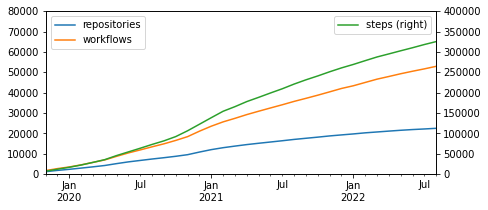

In [6]:
fig, ax = matplotlib.pyplot.subplots()

temp = pd.concat([
    df_repo
    .groupby(pd.Grouper(key='date', freq='M'))
    .agg(repositories=('repository', 'nunique'))
    ,
    df_repo
    .groupby(['repository', 'date'], sort=False, as_index=False)
    .agg(workflows=('filename', 'nunique'))
    .groupby(pd.Grouper(key='date', freq='M'))
    .agg(workflows=('workflows', 'sum'))
    ,
    df_steps
    .groupby('workflow', as_index=False, sort=False)
    .agg(steps=('name', 'count'))
    .merge(
        df_repo[['repository', 'date', 'workflow']],
        how='right',
        on='workflow',
    )
    .groupby(pd.Grouper(key='date', freq='M'))
    .agg(steps=('steps', 'sum'))
], axis=1)

temp[['repositories', 'workflows']].plot(ax=ax)
ax2 = temp[['steps']].plot(ax=ax, secondary_y=True)
ax2.set(ylim=(0, 400000))

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel=None,
    ylim=(0, 80000),
)

savefig(fig, 'overview_repo_workflow_steps')

In [7]:
display(temp.iloc[-1])

repositories     22756.0
workflows        53801.0
steps           330186.0
Name: 2022-09-30 00:00:00, dtype: float64

## Proportion of repositories and steps relying on an Action

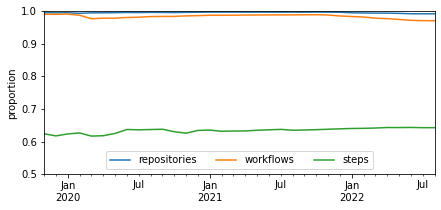

In [8]:
fig, ax = matplotlib.pyplot.subplots()

_ = (
    df_steps
    [['workflow', 'uses']]
    [lambda d: ~d.uses.isnull()]
    [lambda d: ~d.uses.str.startswith(('docker://', './', 'http'))]
    [lambda d: d.uses.str.count('/') == 1]
    .groupby('workflow', as_index=False, sort=False)
    .agg(steps=('uses', 'count'))
    .merge(
        df_repo[['repository', 'date', 'workflow']],
        how='left',
        on='workflow',
    )
    .groupby(pd.Grouper(key='date', freq='M'))
    .agg(repositories=('repository', 'nunique'), workflows=('workflow', 'count'), steps=('steps', 'sum'))
    .assign(repositories=lambda d: d.repositories / temp.repositories)
    .assign(workflows=lambda d: d.workflows / temp.workflows)
    .assign(steps=lambda d: d.steps / temp.steps)
)

_.plot(ax=ax)

ax.legend(loc='lower center', ncol=3)

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='proportion',
    ylim=(0.5, 1)
)

savefig(fig, 'overview_prop_relying_on_actions')

In [9]:
display(_.describe().T)
display(_.iloc[-1])

,count,mean,std,min,25%,50%,75%,max
repositories,35.0,0.995252,0.001699,0.991563,0.994480,0.995561,0.996784,0.997013
workflows,35.0,0.983081,0.006297,0.969090,0.978441,0.985187,0.988049,0.990996
steps,35.0,0.634102,0.007659,0.616878,0.630889,0.636060,0.639646,0.643317


repositories    0.991563
workflows       0.969090
steps           0.643159
Name: 2022-09-30 00:00:00, dtype: float64

## Number of distinct Actions relied on

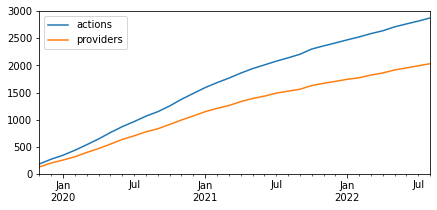

In [10]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_steps
    [['workflow', 'uses']]
    [lambda d: ~d.uses.isnull()]
    [lambda d: ~d.uses.str.startswith(('docker://', './', 'http'))]
    [lambda d: d.uses.str.count('/') == 1]
    .assign(action=lambda d: d.uses.str.split('@', n=1).str[0].str.lower())
    .assign(provider=lambda d: d.uses.str.split('/', n=1).str[0].str.lower())
    .merge(
        df_repo[['repository', 'date', 'workflow']],
        how='left',
        on='workflow',
    )
    .groupby(pd.Grouper(key='date', freq='M'))
    .agg(actions=('action', 'nunique'), providers=('provider', 'nunique'))
)

temp[['actions', 'providers']].plot(ax=ax)

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylim=(0, 3000),
)

savefig(fig, 'overview_nb_distinct_actions')

In [11]:
display(temp.describe().T)
display(temp.iloc[-1])

,count,mean,std,min,25%,50%,75%,max
actions,35.0,1716.171429,850.813538,189.0,1018.0,1859.0,2442.5,2930.0
providers,35.0,1224.000000,595.658311,135.0,743.0,1335.0,1726.5,2064.0


actions      2930
providers    2064
Name: 2022-09-30 00:00:00, dtype: int64

### Reuse concentration (last snapshot), inverted Lorenz curve

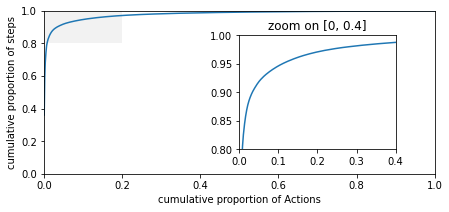

In [12]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_repo[['repository', 'date', 'workflow']]
    # Latest snapshot
    [lambda d: d.date == d.date.max()]
    .merge(
        df_steps[['workflow', 'uses']],
        how='left', 
        on='workflow',
    )
    [lambda d: ~d.uses.isnull()]
    [lambda d: ~d.uses.str.startswith(('docker://', './', 'http'))]
    [lambda d: d.uses.str.count('/') == 1]
    .assign(action=lambda d: d.uses.str.split('@', n=1).str[0].str.lower())
    .groupby('action', as_index=False, sort=False)
    .agg(steps=('uses', 'count'))
    .sort_values('steps', ascending=False)
    .assign(actions=1)
    .assign(
        steps=lambda d: d.steps.cumsum() / d.steps.sum(),
        actions=lambda d: d.actions.cumsum() / d.actions.sum(),
    )
)

temp.set_index('actions').plot(ax=ax, color=PALETTE[0])

ax.legend().remove()
ax.set(
    xlabel='cumulative proportion of Actions',
    xlim=(0, 1),
    ylabel='cumulative proportion of steps', 
    ylim=(0, 1), 
)

ax.add_patch(matplotlib.patches.Rectangle((0, 0.8), 0.2, 0.4, facecolor='k', alpha=0.05))

ax2 = ax.inset_axes([0.5,0.15,0.4,0.7])
temp.set_index('actions').plot(ax=ax2, color=PALETTE[0])
ax2.set(xlabel=None, ylabel=None, xlim=(0, 0.4), ylim=(0.8, 1), title='zoom on [0, 0.4]')
ax2.legend().remove()

savefig(fig, 'overview_reuse_concentration')

In [13]:
temp.query('steps <= 0.8')

,action,steps,actions
0,actions/checkout,0.360206,0.000341
2,actions/cache,0.426051,0.000683
8,actions/upload-artifact,0.486170,0.001024
11,actions/setup-node,0.539659,0.001365
12,actions/setup-python,0.592418,0.001706
29,actions/setup-go,0.617742,0.002048
1,actions/setup-java,0.642898,0.002389
9,actions/download-artifact,0.665128,0.002730
19,actions-rs/toolchain,0.682947,0.003072
20,actions-rs/cargo,0.697003,0.003413


### Specific case for `actions/*`

GitHub distributes the most widely used Actions, such as `checkout` or the various `setup-*`. We made an analysis in the `Technical lag` notebook to quantify the extent to which repositories and steps rely on Actions provided by GitHub. Here we do the same analysis, but considering all steps we have in the dataset (not only those for which we could compute the lags).

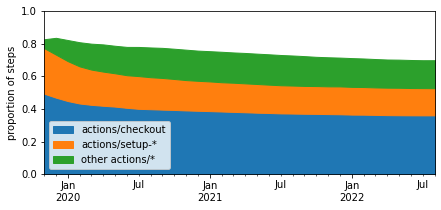

In [14]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_steps
    [['workflow', 'uses']]
    [lambda d: ~d.uses.isnull()]
    [lambda d: ~d.uses.str.startswith(('docker://', './', 'http'))]
    [lambda d: d.uses.str.count('/') == 1]
    .assign(action=lambda d: d.uses.str.split('@', n=1).str[0].str.lower())
    .assign(provider=lambda d: d.uses.str.split('/', n=1).str[0].str.lower())
    .assign(checkout=lambda d: d.action == 'actions/checkout')
    .assign(setup=lambda d: d.action.str.startswith('actions/setup-'))
    .assign(other=lambda d: d.action.str.startswith('actions/'))
    .merge(
        df_repo[['repository', 'date', 'workflow']],
        how='left',
        on='workflow',
    )
    .groupby(pd.Grouper(key='date', freq='M'))
    .agg(
        checkout=('checkout', 'sum'),
        setup=('setup', 'sum'),
        other=('other', 'sum'),
        steps=('uses', 'count'),
    )
    .assign(other=lambda d: d.other - d.setup - d.checkout)
    .assign(remaining=lambda d: d.steps - d.other - d.setup - d.checkout)
    .apply(lambda s: s / s.steps, axis=1)
)

(
    temp
    [['checkout', 'setup', 'other']]
    .rename(columns={'checkout': 'actions/checkout', 'setup': 'actions/setup-*', 'other': 'other actions/*'})
    .plot(ax=ax, kind='area', style=' ', stacked=True, color=PALETTE)
)

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='proportion of steps',
    ylim=(0, 1),
)

savefig(fig, 'overview_prop_steps_github')

In [15]:
display(temp.describe().T)
display(temp.iloc[-1])

,count,mean,std,min,25%,50%,75%,max
checkout,35.0,0.389971,0.032336,0.360206,0.366499,0.379746,0.399601,0.493760
setup,35.0,0.188590,0.028088,0.166211,0.170072,0.177192,0.198012,0.279396
other,35.0,0.170471,0.026462,0.054303,0.171415,0.176556,0.185334,0.186842
steps,35.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
remaining,35.0,0.250967,0.041003,0.163699,0.221244,0.256640,0.286569,0.302667


checkout     0.360206
setup        0.166211
other        0.170916
steps        1.000000
remaining    0.302667
Name: 2022-09-30 00:00:00, dtype: float64

## Distribution of the number of Actions used in a repository

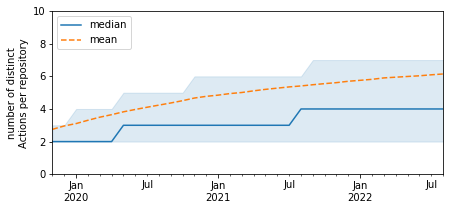

In [16]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    df_steps
    [['workflow', 'uses']]
    [lambda d: ~d.uses.isnull()]
    [lambda d: ~d.uses.str.startswith(('docker://', './', 'http'))]
    [lambda d: d.uses.str.count('/') == 1]
    .assign(action=lambda d: d.uses.str.split('@', n=1).str[0].str.lower())
    .groupby('workflow', as_index=False, sort=False)
    .agg(actions=('action', 'nunique'))
    .merge(
        df_repo[['repository', 'date', 'workflow']],
        how='left',
        on='workflow',
    )
    .groupby(['date', 'repository'], as_index=False, sort=False)
    .agg(actions=('actions', 'sum'))
    .groupby(pd.Grouper(key='date', freq='M'))
    .agg(
        mean=('actions', 'mean'),
        median=('actions', 'median'),
        p25=('actions', lambda s: s.quantile(0.25)),
        p75=('actions', lambda s: s.quantile(0.75)),
    )
)

temp[['median', 'mean']].plot(ax=ax, style={'mean': '--'})
ax.fill_between(temp.index, temp.p25, temp.p75, color=PALETTE[0], alpha=0.15)
ax.legend(loc='upper left')

ax.set(
    xlabel=None,
    xlim=DATE_RANGE,
    ylabel='number of distinct\nActions per repository',
    ylim=(0, 10),
)

savefig(fig, 'overview_distr_nb_actions_per_repo')

In [17]:
temp.describe().T

,count,mean,std,min,25%,50%,75%,max
mean,35.0,4.889171,1.010968,2.751422,4.171721,5.112408,5.728004,6.185605
median,35.0,3.228571,0.731063,2.000000,3.000000,3.000000,4.000000,4.000000
p25,35.0,2.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000
p75,35.0,5.800000,1.231928,3.000000,5.000000,6.000000,7.000000,7.000000
